In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

sns.set_style("dark")

new line d2|"G"B3/2g/2d3/2B/2G3/2B/2d3/2B/2|"D"c3/2e/2a3/2g/2f3/2d/2e3/2f/2|
old line d2|: || |:"G"B3/2g/2d3/2B/2 G3/2B/2d3/2B/2|"D"c3/2e/2a3/2g/2 f3/2d/2e3/2f/2|\
----------
new line A/2|"D"d/2c/2d/2e/2fA|"G"Be"A"cA|"D"d/2c/2d/2e/2f/2e/2d/2c/2|"Em"Be"A"aA|
old line A/2|: || |:"D"d/2c/2d/2e/2 fA|"G"Be "A"cA|"D"d/2c/2d/2e/2 f/2e/2d/2c/2|"Em"Be "A"aA|
----------
new line f|"G"g3/2a/2"D"gf|"G"gd2e|"C"dc"D"BA|"G"BG2A|"G"B"Em"G2A/2B/2|
old line f|: || |:"G"g3/2a/2 "D"gf|"G"gd2e|"C"dc "D"BA|"G"BG2A|"G"B" Em"G2A/2B/2|\
----------
new line G/2|"C"c/2d/2e/2c/2"F"A/2c/2F|"C"c/2d/2e/2c/2"G"B/2d/2d|"C"e/2d/2c/2e/2"D"d/2c/2d/2c/2|"G"B/2c/2d/2g/2"C"e/2c/2c/2B/2|KG|"D"cA/2c/2"G"d/2B/2G/2B/2|"D"cA/2c/2"G"B/2d/2g/2d/2|
old line |: || |:"D"cA/2c/2 "G"d/2B/2G/2B/2|"D"cA/2c/2 "G"B/2d/2g/2d/2|\
----------
new line e|"D"fddcdd|"G"Bdd"A"Ace|"D"fddcdd|"Em"Bee"A"ede|
old line e|: || |:"D"fdd cdd|"G"Bdd "A"Ace|"D"fdd cdd|"Em"Bee "A"ede|
----------
new line d|"G"BddB|"C"ceec|"G"BddB|"Am"e/2d/2c/2B/2"D7"A2|"G"Bdd

<AxesSubplot: xlabel='chords', ylabel='count'>

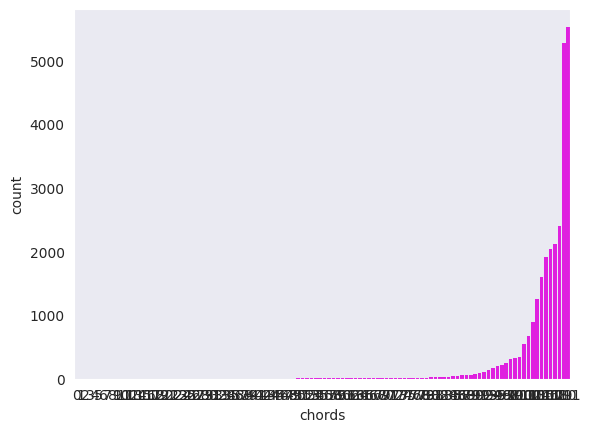

In [2]:
import os
import re
from collections import Counter

global control_var
control_var = True
def get_tuneBooks_file_names(path):
    tuneBook_filenames = []
    
    for tuneBook_name in os.listdir(path):
        if tuneBook_name.endswith('.abc'):
            tuneBook_filenames.append(tuneBook_name)
    
    #return ["jigs.abc"]
    return tuneBook_filenames
def split_abc_song(abc_song):
    k_index = abc_song.find('K:')

    split_index = abc_song.find('\n', k_index)

    header = abc_song[:split_index]
    body = abc_song[split_index+1:]
    return header, body

def tuneBook_to_dataframe(tuneBook):
    song_list = tuneBook.split("\n\n")
    song_list = [song.strip() for song in song_list]
    songs_header_body_format = [split_abc_song(song) for song in song_list if song != '']
    """
    for (h,b) in songs_header_body_format:
        print("header")
        print(h)
        print("*"*10)
        print("body")
        print(b)
        print("\n")
        print("-"*50)
        print("\n")
    """
    
    return pd.DataFrame(songs_header_body_format, columns=['header', 'body'])

def get_attributes_from_song_header(tuneBook_df,tuneBook_name):
    attributes_column = tuneBook_df["header"]
    attributes_list = list(attributes_column)
    
    data = []
    for string in attributes_list:
        song = {}
        for line in string.split("\n"):
            if not line.startswith("%"):
                if ':' in line:
                    key, value = line.split(":", maxsplit=1)
                    song[key.strip()] = value.strip()
        data.append(song)

    df = pd.DataFrame(data)
    descriptive_names = {
                        'X': 'reference_number',
                        'T': 'title',
                        'S': 'source',
                        'M': 'meter',
                        'L': 'unit_note_length',
                        'R': 'rhythm',
                        'P': 'parts',
                        'K': 'key',
                        'F': 'file_name',
                        'N': 'notes'
                        }
    df.rename(columns=descriptive_names, inplace=True)
    df["tuneBook"] = tuneBook_name
    df["original_header"] =  tuneBook_df["header"]
    df["original_body"] =  tuneBook_df["body"]
    
    return df

def get_chord_progression(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    for bar_content in bars:
        match_chords = r'"[^"]*"'
        chords = re.findall(match_chords, bar_content)
        bar_chords = ''.join(chords)
        if bar_chords != "":
            chord_progression += bar_chords +'|'
    return chord_progression

def get_chord_occurrences(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    match_chords = r'"[^"]*"'
    chords = [re.findall(match_chords, bar_content)  for bar_content in bars if bar_content]
    chords = [chord for bar_chords in chords for chord in bar_chords]
    chord_occurrences = dict(Counter(chords))
    return chord_occurrences

def get_chords_data(song_body=""):
    #song_body = 'P:A\nD|"Gm"GB2G|"D7"^Fd2D|"Gm"GB2G|"D7"^FA2D|"Gm"GB2G|"D"^Fg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|\nP:B\nd|"Gm"dg2d|"Gm"gb2d|"F"cf2c|"F"fa2c|"Eb"Be2d/2c/2|"Gm"dg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|'
    clean_body_song = ""
    match_pattern = ""
    for line in song_body.splitlines():
        #if not line.startswith("%"):
            #if not "P:" in line:
        if not line.startswith(('P:', 'M:', '%', "L:")):
            #print("Header detected!!!",line)
            new_line = line.strip("\\")
            match_pattern = r"[: ]"
            new_line = re.sub(match_pattern, "", new_line)
            clean_body_song = clean_body_song+new_line
            if('||||' in clean_body_song):
                match_pattern = r'\|\|\|\|'
                clean_body_song = re.sub(match_pattern, "|", clean_body_song)
                print("new line",clean_body_song)
                print("old line",line)
                print("-"*10)
    
    chord_progression = get_chord_progression(clean_body_song)
    chords_data = get_chord_occurrences(clean_body_song)
    chords_data["chord_progression"] = chord_progression
    chords_data["clean_body"] = clean_body_song
    return chords_data

### treat strings line by line to ignore comments and parts!!!!!
def get_song_characteristics_from_body(tuneBook_df, header_col_name="original_body"):
    songs_bodies=tuneBook_df[header_col_name]
    #global control_var
    #print(songs_bodies)
    #if(control_var):
        #control_var = False
    #df = tuneBook_df.join(songs_bodies.apply(get_chords_data))
    new_data = songs_bodies.apply(get_chords_data)
    chords_df = new_data.apply(pd.Series)
    chords = chords_df['chord_progression']
    chords_df = chords_df.drop('chord_progression', axis=1)
    chords_df["chord_progression"] = chords
    tuneBook_df = tuneBook_df.join(chords_df)
    #print(tuneBook_df.columns)
    #print("*"*20)   
    # get anacrusis bool to see that the dataset is balanced
    #tuneBook["num_notes_per_bar"] # count num -> useless? to measure intensity?
    #tuneBook["num_bars"] # count number of || ins song -> to detect possible outliers?
    #tuneBook["num_notes_in_song"] # count a,b,c,d...in string, match regex "a"   
    #tuneBook["chord_progression"] #string "|"C"|"Dm"|" -> to count chords and to have a "Tree view of common chord progressions"
    #tuneBook["multiple_parts"] #bool -> to treat songs with multiple parts
    ##  Count types of notes in each song to see the proportion of notes for a given key
    ## Maybe by chord also?
    return tuneBook_df
def get_songs_metadata(songs_dataframe, tuneBook_name):
    #songs_dataframe["number_in_tunebook"] = get_attributes_from_song_header(songs_dataframe)
    df = get_attributes_from_song_header(songs_dataframe,tuneBook_name)
    df = get_song_characteristics_from_body(df)
    return df

def get_chord_columns_as_occurrences(songs_df):
    chords_names = songs_df.columns[songs_df.columns.str.contains('"[^"]*"')]
    chords_occurrences = songs_df[chords_names].sum()
    return chords_occurrences



def drop_rows_by_chord_occurrence(songs_df,drop_threshold=15):
    
    chords_occurrences = get_chord_columns_as_occurrences(songs_df)
    ## Gets the names of the chords that appear less times than the threshold.
    chords_names_least_occurrences = chords_occurrences[chords_occurrences<drop_threshold].index.to_list()
    print("number chords least occurrences: ",len(chords_names_least_occurrences))
    print("chords least occurrences",chords_names_least_occurrences)

    ## Applies a logical OR to the selected columns in order to drop the rows that have a value in the corresponding column
    mask_drop_songs_with_low_chords_sample = songs_df[chords_names_least_occurrences].apply(lambda row: row>0).any(axis=1)
    drop_num = mask_drop_songs_with_low_chords_sample.value_counts()
    print("number of values to be dropped:\n",drop_num)

    ##Apply the negative mask to preserve the rows that don't have occurrences of the selected chords
    clean_songs_df = songs_df[~mask_drop_songs_with_low_chords_sample]

    ##Drop columns of useless chords
    clean_songs_df = clean_songs_df.drop(chords_names_least_occurrences, axis=1)
    clean_songs_df = clean_songs_df.reset_index(drop=True)

    return clean_songs_df

def drop_rows_by_extended_chords(songs_df,chords_to_drop=[]):
    
    chords_occurrences = get_chord_columns_as_occurrences(songs_df)

    ## Gets the names of the chords that have '/' 
    extended_chords_names = songs_df.columns[songs_df.columns.str.contains("/")].to_list()
    extended_chords_names = extended_chords_names + chords_to_drop

    ## Applies a logical OR to the selected columns in order to drop the rows that have a value in the corresponding column
    mask_drop_songs_with_extended_chords = songs_df[extended_chords_names].apply(lambda row: row>0).any(axis=1)
    drop_num = mask_drop_songs_with_extended_chords.value_counts()
    print("number of values to be dropped:\n",drop_num)

    ##Apply the negative mask to preserve the rows that don't have occurrences of the selected chords
    clean_songs_df = songs_df[~mask_drop_songs_with_extended_chords]

    ##Drop columns of useless chords
    clean_songs_df = clean_songs_df.drop(extended_chords_names, axis=1)
    clean_songs_df = clean_songs_df.reset_index(drop=True)

    return clean_songs_df


def count_bars_in_songs(songs_df):
    return 0

def calculate_note_length(songs_df_row,col_name="unit_note_length"):
    new_note_length = ""
    ## See: https://abcnotation.com/wiki/abc:standard:v2.1#lunit_note_length 
    map_meter_to_note_length = {
        "4/4":"1/8",
        "6/8":"1/8",
        "3/4":"1/8",
        "2/4":"1/16",
        "9/8":"1/8",
        "2/2":"1/8",
        "3/2":"1/8",
        "6/4":"1/8"
    }
    if(pd.isna(songs_df_row[col_name])):
        print("NA detected!")
        meter = songs_df_row["meter"]
        new_note_length = map_meter_to_note_length[meter]
    else:
        new_note_length = songs_df_row[col_name]

    return new_note_length

def fill_missing_note_length(songs_df):
    col_with_na = "unit_note_length"
    songs_df[col_with_na] = songs_df.apply(calculate_note_length,axis=1)
    return songs_df

def drop_useless_columns(df,drop_columns=["Y","notes","parts","rhythm","source"]):
    clean_df = df
    df_columns = clean_df.columns
    for useless_column in drop_columns:
        if(useless_column in df_columns):
            clean_df = clean_df.drop(useless_column, axis=1)
    return clean_df


def prepare_dataset_for_EDA(relative_path="",drop_by_occurrences=True, drop_by_extended_chord=True, min_chord_progression_length=20):
    absolute_path = os.getcwd()
    #relative_path = "notebooks/data/NottinghamData/nottingham_database"
    relative_path = "notebooks/data/NottinghamCleaned/nottingham_match/python/data/nottingham_jukedeck/ABC_cleaned"
    absolute_path = os.path.join(absolute_path, relative_path)
    songs_df = pd.DataFrame()
    list_tuneBooks = get_tuneBooks_file_names(absolute_path)
    for abc_tuneBook_filename in list_tuneBooks:
        file_path = os.path.join(absolute_path, abc_tuneBook_filename)
        
        with open(file_path) as tuneBook:
            contents = tuneBook.read()
            df = tuneBook_to_dataframe(contents)
            df1 = get_songs_metadata(df,abc_tuneBook_filename)
            songs_df = pd.concat([songs_df, df1], ignore_index=True)

    ## Sets chords columns as int types
    chords_names = songs_df.columns[songs_df.columns.str.contains('"[^"]*"')]
    songs_df[chords_names] = songs_df[chords_names].fillna(0).astype(int)


    chords_occurrences = songs_df[chords_names].sum().sort_values(ascending=True)

    chords_occurrences = chords_occurrences.reset_index(drop=True)
    chords_occurrences = chords_occurrences.reset_index()
    chords_occurrences_before_drop = chords_occurrences.rename({0:"count","index":"chords"},axis=1)
    
    clean_songs_df = songs_df
    clean_songs_df = drop_useless_columns(clean_songs_df)

    if(drop_by_occurrences):
        clean_songs_df = drop_rows_by_chord_occurrence(clean_songs_df)


    if(drop_by_extended_chord):
        clean_songs_df = drop_rows_by_extended_chords(clean_songs_df)

    ## Drops rows that don't have the minimum chord progression length
    mask_no_chord_progression = clean_songs_df["chord_progression"].str.len()>min_chord_progression_length
    clean_songs_df = clean_songs_df[mask_no_chord_progression]
    clean_songs_df = clean_songs_df.reset_index(drop=True)

    ## X: 102 meter appears after they key so its meter is dropped in the cleaning.
    ## its the only song with this format
    clean_songs_df.loc[clean_songs_df["meter"].isna(),"meter"] = "6/8"
    
    ## Fill empty values of note_length according to the meter of the song
    clean_songs_df = fill_missing_note_length(clean_songs_df)

    #for song in clean_songs_df["chord_progression"]:
    #    print(song)
    #    print("**"*10)
    return songs_df, clean_songs_df, chords_occurrences_before_drop

songs_df, clean_songs_df,chords_occurrences = prepare_dataset_for_EDA()
#chords_occurrences["count"] = chords_occurrences["count"].apply(np.log)
sns.barplot(data=chords_occurrences,y="count", x='chords',edgecolor='none',color="magenta")


In [3]:
songs_df["original_body"].str.contains("P:")

0        True
1        True
2       False
3       False
4        True
        ...  
1029    False
1030    False
1031     True
1032    False
1033    False
Name: original_body, Length: 1034, dtype: bool

Index(['index', 0], dtype='object')


<AxesSubplot: xlabel='0', ylabel='index'>

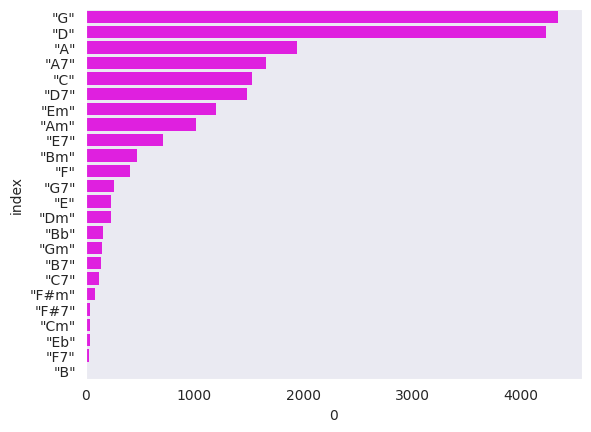

In [4]:
chords_names = clean_songs_df.columns[clean_songs_df.columns.str.contains('"[^"]*"')]

chords_occurrences_df = clean_songs_df[chords_names].sum().sort_values(ascending=False).reset_index()
print(chords_occurrences_df.columns)
sns.barplot(data=chords_occurrences_df,y="index", x=0,edgecolor='none',color="magenta")

<AxesSubplot: xlabel='key', ylabel='Count'>

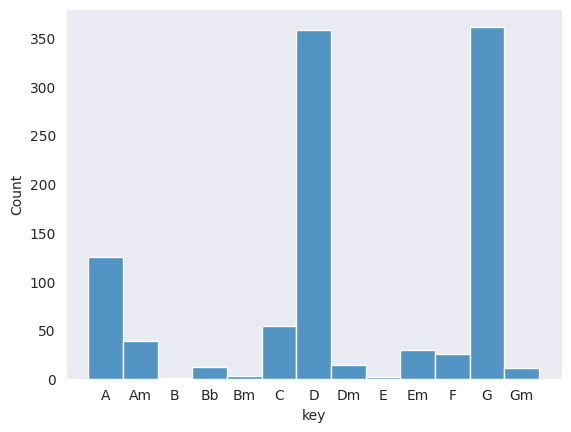

In [5]:
sns.histplot(songs_df["key"].astype("category"))

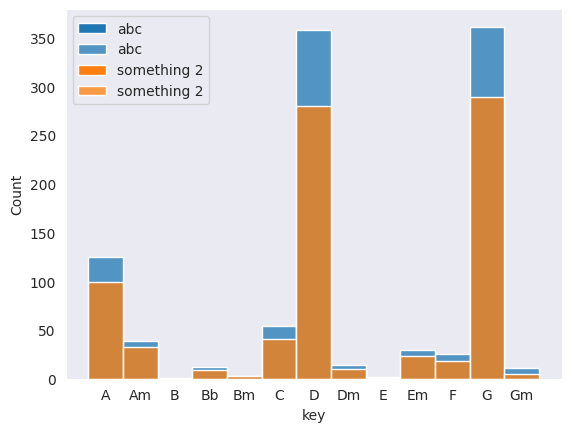

In [6]:
#fig, ax = plt.subplots()
ax = sns.histplot(songs_df["key"].astype("category"),label="abc")
ax = sns.histplot(clean_songs_df["key"].astype("category"), ax=ax,label="something 2")
ax.legend()
plt.show()

In [7]:
clean_songs_df.columns[clean_songs_df.columns.str.contains('"[\(]')]

Index([], dtype='object')

In [8]:
chord_names = clean_songs_df.columns[clean_songs_df.columns.str.contains('"')].to_list()
sum_chords = clean_songs_df[chord_names].sum().sort_values().reset_index()
chords = "|"
for chord_name,chord_count in zip(sum_chords["index"],sum_chords[0]):
    chords = chords+chord_name+'|'
    print(chord_name,chord_count)
print(chords)

"B" 17
"F7" 33
"Eb" 37
"Cm" 38
"F#7" 39
"F#m" 88
"C7" 120
"B7" 138
"Gm" 148
"Bb" 157
"Dm" 232
"E" 238
"G7" 258
"F" 407
"Bm" 473
"E7" 716
"Am" 1018
"Em" 1195
"D7" 1484
"C" 1529
"A7" 1654
"A" 1946
"D" 4232
"G" 4338
|"B"|"F7"|"Eb"|"Cm"|"F#7"|"F#m"|"C7"|"B7"|"Gm"|"Bb"|"Dm"|"E"|"G7"|"F"|"Bm"|"E7"|"Am"|"Em"|"D7"|"C"|"A7"|"A"|"D"|"G"|


In [9]:
print(clean_songs_df["chord_progression"].str.contains("segno").value_counts())

False    811
Name: chord_progression, dtype: int64


In [10]:
print(songs_df["chord_progression"].str.contains("segno").value_counts())

False    1034
Name: chord_progression, dtype: int64


In [11]:
for song,title,book in zip(clean_songs_df["clean_body"],clean_songs_df["title"],clean_songs_df["tuneBook"]):
    print(title," ", book)
    print(song)
    print("**"*10)

The Indian Queen   playford.abc
f/2g/2|"D"afdf|"A7"e2A2|"D"FAAf|"Em"e2-"A7"ef/2g/2|"D"afdf|"A7"e2A2|"D"FAAf|"D"d3|c/2d/2|"A"e/2d/2c/2B/2Ae|"F#m"fc"Bm"dB|"D"f/2g/2a"E7"b^g|"A7"a3e/2f/2|"G"g/2f/2e/2d/2"A"ca|"Em"Bg"A7"Af/2g/2|"G"ed"A7"ec|"D"d3|
********************
Mr Beveridge's Maggot   playford.abc
"Gm"g4"D7"^f2=ef"Gm"g4|"Cm"d2cB"D7"ABc2"Gm"B2G2|"Gm"g4"F7"a2ga"Bb"b4|"Eb"f2ed"F7"cde2"Bb"d2B2|"Bb"d2f4f2f4|"F"c2e4e2e4|"Gm"B2d4d2d2cB|"Cm"ABc2"A7"B2AG"D7"^F2D2|"D7"d2a4a2a2d2|"Gm"b2a2"D7"g2^f2"Gm"g4|"Bb"def2Bcd2"F"ABc2|"Cm"B2G2"D7"G2^F2"Gm"G4|
********************
Nancy's Fancy   playford.abc
|D|"G"GBBA/2B/2|"D7"cAAd|"G"BGGB|"Am"A/2G/2F/2E/2"D7"DD|"G"GB"Em"BA/2B/2|"Am"cA"D7"Ad|"G"BG"D7"AF|"G"G2G||g|fedc|"G"BAGB|"G"dgdB|"D"B2Ag|fedc|BABc|"G"dg"D7"fd|"G"g2g2|"Em"BBB/2A/2B|"Am"ccc/2B/2c|"Em"BBB/2A/2B|"D7"A/2G/2F/2E/2DD|"Em"BBB/2A/2B|"Am"ccc/2B/2c|"Em"BG"D7"AF|"G"G2G|
********************
Never Love Thee More   playford.abc
"G"DEDG2A|"G"BcBA2G|"G7"dB2A2G|"C"E3-E3|"G"DEDG2A|"G"BcBA2G|"G"dB2c2d|"C

In [12]:
descriptive_names = {
                        'X': 'reference_number',
                        'T': 'title',
                        'S': 'source',
                        'M': 'meter',
                        'L': 'unit_note_length',
                        'R': 'rhythm',
                        'P': 'parts',
                        'K': 'key',
                        'F': 'file_name',
                        'N': 'notes'
                        }

4/4    440
6/8    279
3/4     38
2/4     37
9/8     10
2/2      5
3/2      1
6/4      1
Name: meter, dtype: int64

Sum of values: 811

NaN values: 0


<AxesSubplot: xlabel='meter', ylabel='Count'>

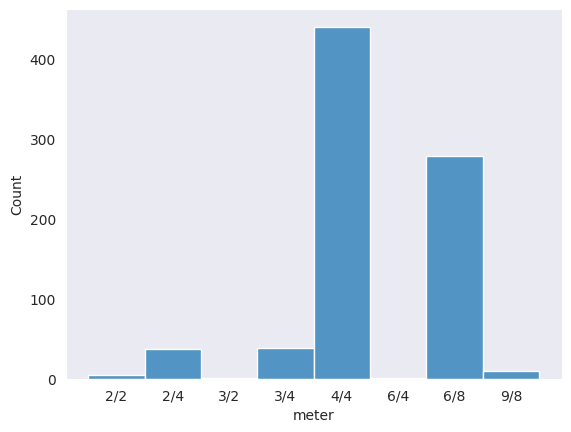

In [13]:
category_name = "meter"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

Hornpipe    65
Name: rhythm, dtype: int64

Sum of values: 65

NaN values: 969


<AxesSubplot: xlabel='rhythm', ylabel='Count'>

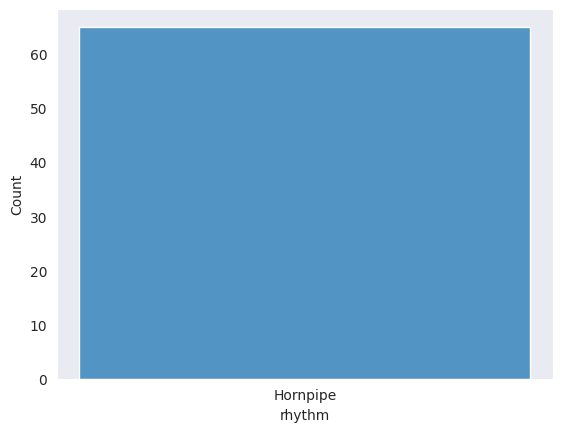

In [14]:
category_name = "rhythm"
category_value_counts = songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",songs_df[category_name].isna().sum())
sns.histplot(songs_df[category_name].astype("category"))

1/4    448
1/8    363
Name: unit_note_length, dtype: int64

Sum of values: 811

NaN values: 0


<AxesSubplot: xlabel='unit_note_length', ylabel='Count'>

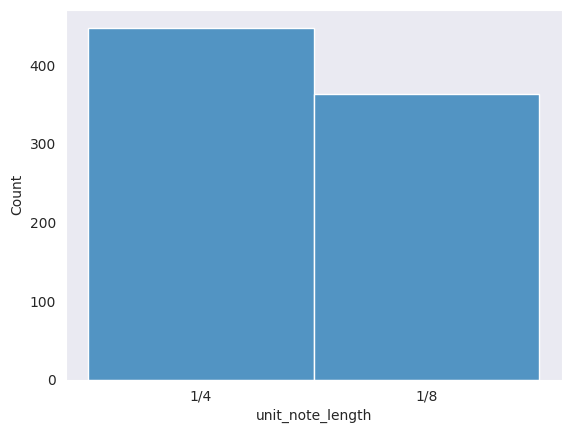

In [15]:
category_name = "unit_note_length"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

G     289
D     280
A      99
C      41
Am     33
Em     23
F      18
Dm     10
Bb      9
Gm      5
Bm      3
E       1
Name: key, dtype: int64

Sum of values: 811

NaN values: 0


<AxesSubplot: xlabel='key', ylabel='Count'>

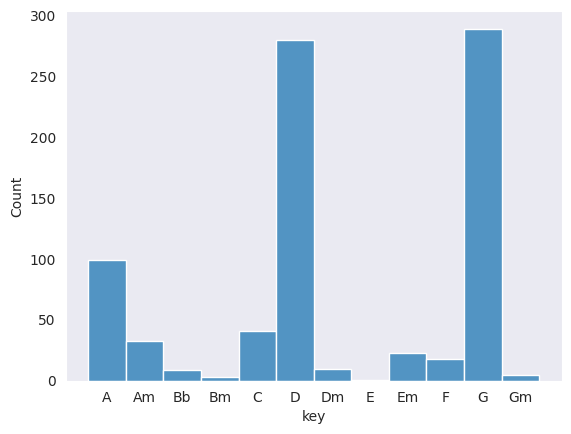

In [16]:
category_name = "key"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

jigs.abc        260
reelsr-t.abc     75
reelsh-l.abc     71
reelsd-g.abc     70
reelsm-q.abc     68
reelsa-c.abc     62
hpps.abc         57
ashover.abc      43
waltzes.abc      31
reelsu-z.abc     26
morris.abc       18
slip.abc         11
playford.abc     10
xmas.abc          9
Name: tuneBook, dtype: int64

Sum of values: 811

NaN values: 0


<AxesSubplot: xlabel='Count', ylabel='tuneBook'>

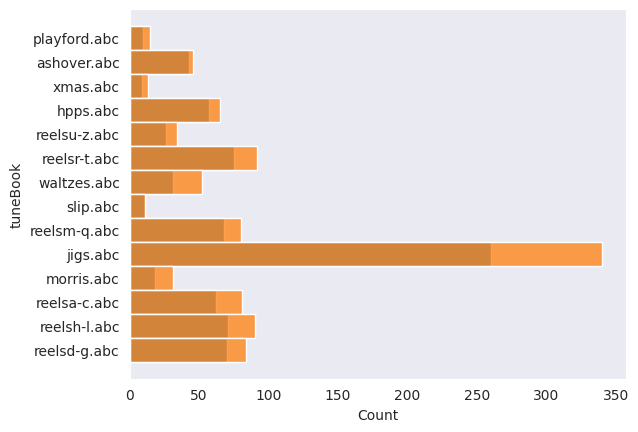

In [17]:
category_name = "tuneBook"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df, y=category_name)
sns.histplot(songs_df, y=category_name)

In [18]:
clean_songs_df["meter"].value_counts()

4/4    440
6/8    279
3/4     38
2/4     37
9/8     10
2/2      5
3/2      1
6/4      1
Name: meter, dtype: int64

In [19]:
clean_songs_df["meter"].isna().sum()

0

In [20]:
print(clean_songs_df["unit_note_length"].value_counts())
print(clean_songs_df["unit_note_length"].isna().sum())

1/4    448
1/8    363
Name: unit_note_length, dtype: int64
0


In [21]:
clean_songs_df.columns.sort_values()

Index(['"A"', '"A7"', '"Am"', '"B"', '"B7"', '"Bb"', '"Bm"', '"C"', '"C7"',
       '"Cm"', '"D"', '"D7"', '"Dm"', '"E"', '"E7"', '"Eb"', '"Em"', '"F"',
       '"F#7"', '"F#m"', '"F7"', '"G"', '"G7"', '"Gm"', 'chord_progression',
       'clean_body', 'key', 'meter', 'original_body', 'original_header',
       'reference_number', 'title', 'tuneBook', 'unit_note_length'],
      dtype='object')

In [23]:
print("Number of NaN in the entire dataset:",clean_songs_df.isna().sum().sum())

Numer of NaN in the entire dataset: 0
